# Person detection using the Yolo algorithm

In [161]:
import os

In [96]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imsave
%matplotlib inline

Whereas the ImageAI library https://github.com/OlafenwaMoses/ImageAI provides a convenient interface, the [implementation](https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Detection/__init__.py) itself is  badly structured... So, we did a small rewrite of the code, focusing on the yolo based detection only. More specific, the code is a rewrite of https://github.com/OlafenwaMoses/ImageAI/blob/master/imageai/Detection/__init__.py

In [97]:
from yolo_detecion import YoloObjectDetection

In [98]:
photo_folder = "../data/raw"
output_dir = "../data/processed/yolo_model"
output_dir_extracts = "../data/processed/extractions"

Initialize model

In [11]:
detector = YoloObjectDetection("./model/yolo.h5", detection_speed="normal")

Running over the different images and identifying relevant objects:

In [150]:
image_data = dict()

selected_classes = ["person", "car", "bicycle", "motorcycle"]

for filename in os.listdir("../data/raw"):
    print(filename)
    image = cv2.imread(os.path.join(photo_folder, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # detect image
    detected_objects = detector.detect_objects(
        image, minimum_percentage_probability = 50, 
        custom_objects = selected_classes)
    image_data[filename] = detected_objects
    
    # create updated image
    #annotated_image = detector.plot_objects(image, detected_objects, 
    #                     display_meta_info = False)
    
    # save the output file  - comment out if not interested
    #imsave(os.path.join(output_dir, 
    #                         os.path.basename(filename)), 
    #       annotated_image)
    
    # extract the persons itself ot individual images for later usage  - comment out if not interested
    for j, identified in enumerate(detected_objects):
        box = identified['box_points']

        # extract person image to get face
        face_image = image[box[1]:box[3], box[0]:box[2]]
        imsave(os.path.join(output_dir_extracts, filename + "_" + str(j) + ".png"), 
               face_image)    

IMAG0065.JPG
dog with probability: 0.14436048
person with probability: 0.6707307
person with probability: 0.94197744
IMAG0013.JPG
car with probability: 0.91430163
car with probability: 0.98338914
IMAG0049.JPG
person with probability: 0.99750686
person with probability: 0.99805945
IMAG0044.JPG
bird with probability: 0.1319789
person with probability: 0.8947271
person with probability: 0.9304717
IMAG0069.JPG
dog with probability: 0.2933633
person with probability: 0.99189496
person with probability: 0.9987155
_DSC6275.JPG
dining table with probability: 0.11616816
chair with probability: 0.21518995
sandwich with probability: 0.17546917
bottle with probability: 0.1472154
bottle with probability: 0.39634112
bottle with probability: 0.6709426
bottle with probability: 0.8176315
person with probability: 0.2895891
person with probability: 0.38087437
person with probability: 0.94985235
person with probability: 0.99984527
IMAG0052.JPG
handbag with probability: 0.19104765
backpack with probability

Based on these `detected_objects`, we can now adjust the images, e.g. add rectangle on top of the persons:

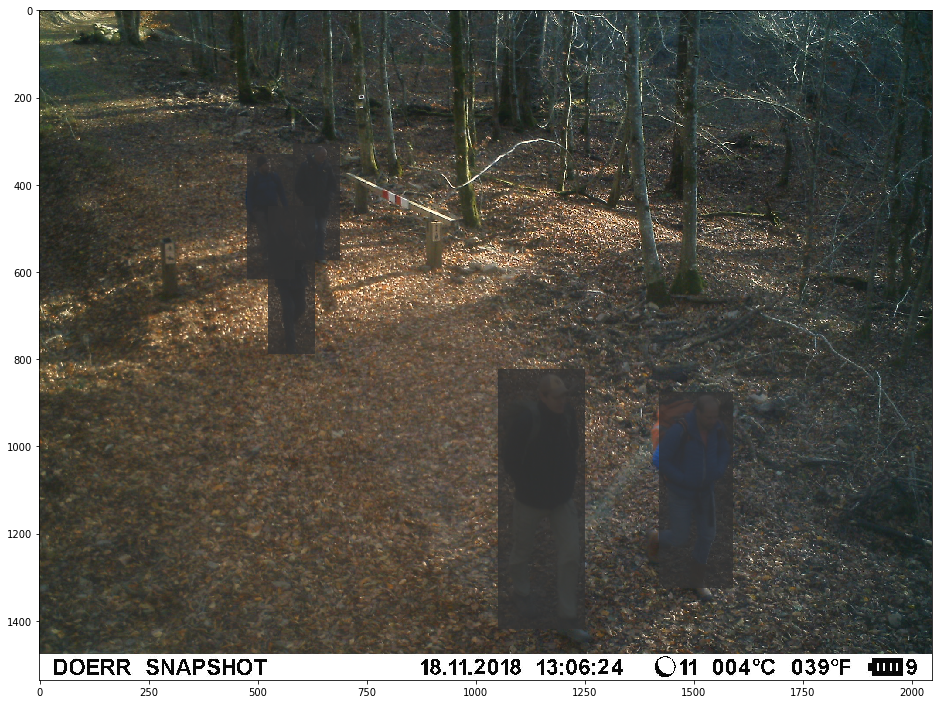

In [133]:
import matplotlib.patches as patches
fig, ax  = plt.subplots(figsize=(16, 16))

image = cv2.imread(os.path.join(photo_folder, filename))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax.imshow(image)

# Create a Rectangle patch
for j, identified in enumerate(detected_objects):
    box = identified['box_points']
    rect = patches.Rectangle((box[0], box[-1]), box[2]-box[0], box[1]-box[-1],
                      linewidth=0, edgecolor='none', facecolor='0.2', alpha=0.8)
    ax.add_patch(rect)

or, blur a __top level percentage__ of each person:

In [145]:
import matplotlib.patches as patches
#fg, ax  = plt.subplots(figsize=(16, 16))

image = cv2.imread(os.path.join(photo_folder, filename))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

blur_percentage = 0.25

# Blur a percentage of each person
for j, identified in enumerate(detected_objects):
    box = identified['box_points']
    
    # Extract the region of the image that contains the face
    endpoint = int(box[1] + (box[3] - box[1])*blur_percentage)
    person_image = image[box[1]:endpoint, box[0]:box[2]]

    # Blur the top n% of the image
    person_image = cv2.GaussianBlur(person_image, (25, 25), 25)

    # Put the blurred face region back into the frame image
    image[box[1]:endpoint, box[0]:box[2]] = person_image

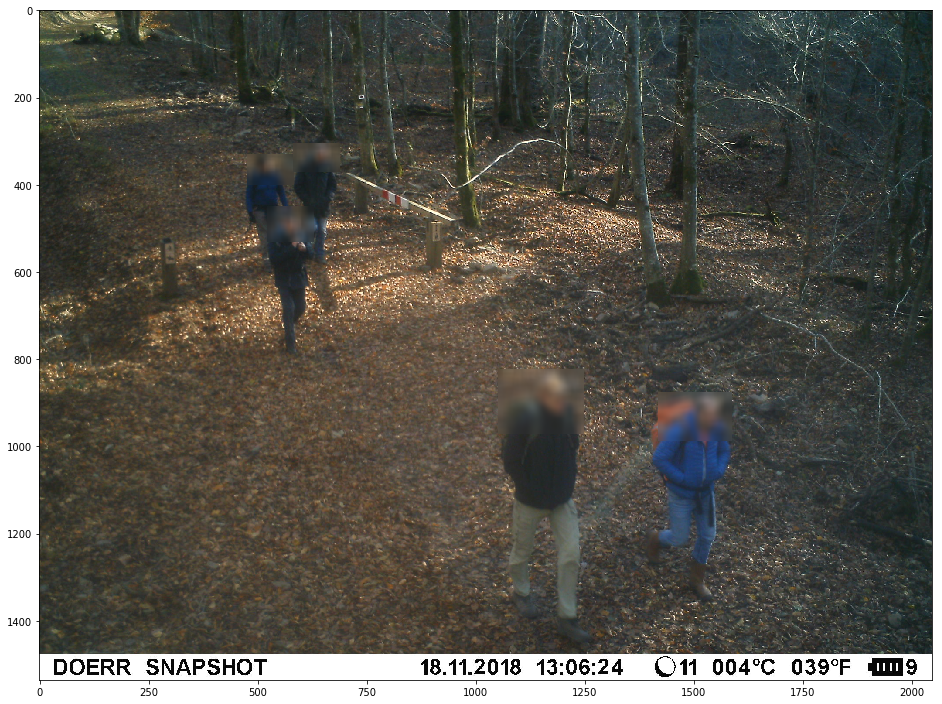

In [146]:
fig, ax  = plt.subplots(figsize=(16, 16))
ax.imshow(image)

Note, the percentage blurring is a rather naive way, as it will be camera-setup dependent. However, it could be a pragmatic solution at the same time and improved a bit by taking into account the width/height ratio... [Wikipedia](https://en.wikipedia.org/wiki/Body_proportions) says 

> An average person is generally 7-and-a-half heads tall (including the head).

So, for people with full body on the picture, blurring aournd 15% should be ok (take 25 to be sure) and let's just assume that people width height/width ratio > 2 only require the 25% blurring. if ratio < 2, the ratio  should increase...

In [169]:
import numpy as np

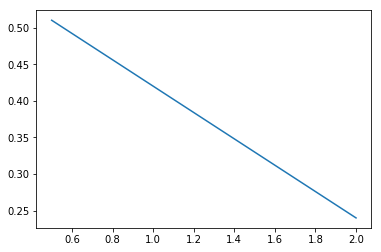

In [205]:
x = np.array([0.5, 2.])
y = -0.18*x + .6
plt.plot(x, y)

In [207]:
import matplotlib.patches as patches


def blur_percentage(height, width):
    """tryout function  to define person blur percentage"""
    ratio = height/width
    
    if ratio >= 2.:
        blur_percentage = 0.25
    else:
        blur_percentage = -0.18*ratio + .6 # linear increase of percentage when ratio decreases, just dummy
    return blur_percentage
        

for filename, detected_objects in image_data.items():

    image = cv2.imread(os.path.join(photo_folder, filename))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for j, identified in enumerate(detected_objects):
        
        if identified['name'] == "person":
            box = identified['box_points']
            
            height = box[3] - box[1]
            width = box[2] - box[0]
            blur_perc = blur_percentage(height, width)
            print(height/width, filename, blur_perc)
                
            # Extract the region of the image that contains the face
            endpoint = int(box[1] + (box[3] - box[1])*blur_perc)
            person_image = image[box[1]:endpoint, box[0]:box[2]]

            # Blur the top n% of the image
            person_image = cv2.GaussianBlur(person_image, (25, 25), 25)

            # Put the blurred face region back into the frame image
            image[box[1]:endpoint, box[0]:box[2]] = person_image
        
        
        # save the image
        imsave(os.path.join(output_dir, 
                            os.path.basename(filename)), 
               image)        

2.6315789473684212 IMAG0069.JPG 0.25
2.5828220858895707 IMAG0069.JPG 0.25
2.580357142857143 IMAG0049.JPG 0.25
2.3018018018018016 IMAG0049.JPG 0.25
2.623853211009174 IMAG0038.JPG 0.25
3.1588785046728973 IMAG0038.JPG 0.25
2.462962962962963 IMAG0038.JPG 0.25
2.6470588235294117 IMAG0038.JPG 0.25
2.9949748743718594 IMAG0038.JPG 0.25
2.966666666666667 IMAG0060.JPG 0.25
2.26775956284153 IMAG0060.JPG 0.25
2.4011627906976742 IMAG0057.JPG 0.25
2.418181818181818 IMAG0057.JPG 0.25
2.0405405405405403 IMAG0052.JPG 0.25
2.5085714285714285 IMAG0010.JPG 0.25
2.887323943661972 _DSC6275.JPG 0.25
1.8952569169960474 _DSC6275.JPG 0.25885375494071144
0.7195767195767195 IMAG0054.JPG 0.4704761904761905
2.83248730964467 IMAG0054.JPG 0.25
2.5755395683453237 IMAG0044.JPG 0.25
2.6226415094339623 IMAG0044.JPG 0.25
2.0277777777777777 IMAG0005.JPG 0.25
3.9469026548672566 IMAG0065.JPG 0.25
2.6706586826347305 IMAG0065.JPG 0.25
2.514705882352941 IMAG0046.JPG 0.25
2.6814814814814816 IMAG0056.JPG 0.25
2.442622950819672 IM